### SET game: Modularity and comparison to purely symbolic representations

This notebook implements the experiment described in Section 4.5 and shown in Figure 2 (b). 

As described in Section 4.5, in the SET game, players are
presented with 12 cards, each of which contains figures that vary along four dimensions (color, number, pattern, and
shape) and they must find subsets of three cards which obey a deceptively simple rule: along each dimension, all cards in a SET must either have the same or unique values.

To simulate the task of deciding if a triple forms a SET, we first train a convolutional neural network to process the color images of the cards (a full deck includes 81 cards). The CNN is trained to predict the attribute of
each card, as a multi-label classification, and then an embedding of dimension $d=32$ of 
each card is obtained. This embedding layer uses an MLP to map the convolutional feature maps into a distributed
representation. Next, we train Abstractors separately for each of the four attributes to learn same/different
relations, where the task is to decide if an input pair of cards is the same or different for that attribute. 
We then use the query and key mappings $W_Q$ and $W_K$ learned for these relations to initialize the relations
in a multi-head Abstractor. The Abstractor is then trained on a dataset of triples of cards, half of which form a SET. 

This is compared to a baseline symbolic model where, instead of images, the input is a vector with 12 bits,
explicitly encoding the relations. That is, for each of the four attributes, a binary symbol is computed for each pair of three input cards---1 if the pair is the same in that attribute, and 0 otherwise. A two-layer MLP is then trained to decide if the triple forms a SET. The MLP using the symbolic representation can be considered as a lower bound on the performance achievable by the Abstractor. This comparison shows that the Abstractor is able to solve a task using relations learned in other tasks (modularity), with a sample efficiency that is not far from that obtained
with purely symbolic, noise-free encodings of the relevant relations.

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# We implemented a module that allows easy simulation and modeling of the SET game
from setGame import *
import tensorflow as tf


In [2]:
setgame = SetGame()

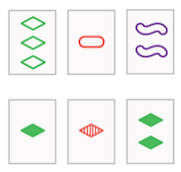

In [3]:
# The following cell deals 6 cards, in such a way that is guaranteed to include a SET. Can you find one? 
# The game is usually played with 12 cards rather than 6.

num_cards=6
obs, _, _ = setgame.init_state(num_cards=num_cards, shuffle=True)
hand = setgame.state.dealt_cards


k = int(len(hand)/3)
obsfig, axarr = plt.subplots(k, 3, figsize=(3,k*1.5))
for i in range(k):
    for j in range(3):
        card = hand[3*i+j]
        axarr[i,j].imshow(setgame.image_of_card(card[0], card[1]))
        axarr[i,j].axis('off')
plt.show()


The Abstractor will work from images of the cards. We first train a simple CNN that is trained to 
label a card with each of its four attributes. This is treated as a multi-label classification problem. 
The attributes are encoded as 12-vectors of bits, arranged in 4 groups of 1-hot 3-vectors.

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split

class SetEmbedder():
    def __init__(self, ff_dim1=128, ff_dim2=32):
        img_input = layers.Input(shape=(70, 50, 4))
        x = layers.Conv2D(32, (5, 5), activation='relu')(img_input)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Conv2D(32, (5, 5), activation='relu')(x)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(ff_dim1, activation='relu')(x)
        self.embedding_layer = layers.Dense(ff_dim2, activation='tanh')(x)
        outputs = layers.Dense(12, activation='sigmoid')(self.embedding_layer)
        self.model = Model(inputs=img_input, outputs=outputs)
        self.embed = Model(inputs=img_input, outputs=self.embedding_layer)
        self.model.summary()
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train, epochs=2):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test, verbose=0)
        return out

    def embed(self, X_test):
        out = self.embed(X_test, verbose=0)
        return out

In [5]:
def convert_to_binary(attrs):
    color = {'red':[1,0,0], 'green':[0,1,0], 'purple':[0,0,1]}
    pattern = {'empty':[1,0,0], 'striped':[0,1,0], 'solid':[0,0,1]}
    shape = {'diamond':[1,0,0], 'oval':[0,1,0], 'squiggle':[0,0,1]}
    number = {'one':[1,0,0], 'two':[0,1,0], 'three':[0,0,1]}
    binary_attrs = number[attrs[0]] + color[attrs[1]] + pattern[attrs[2]] + shape[attrs[3]]
    return binary_attrs

n = 1000
X = np.empty((n, 70, 50, 4), dtype=np.float32)
y = np.empty((n, 12), dtype=int)

card_coord = [(i,j) for i in np.arange(9) for j in np.arange(9)]
for i in np.arange(n):
    c = np.random.choice(np.arange(81), size=1)[0]
    (row, col) = card_coord[c]
    attrs = setgame.attributes_of_card(row, col)
    binary_attrs = convert_to_binary(attrs)
    X[i] = setgame.image_of_card(row, col)
    y[i] = binary_attrs


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
cnn = SetEmbedder(ff_dim1=64, ff_dim2=32)
cnn.train(X_train, y_train, epochs=20)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 50, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 66, 46, 32)        3232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 7, 32)         25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 96)                0     

In [7]:
for i in range(5):
    j = np.random.choice(range(X_test.shape[0]))
    pred = np.round(cnn.predict(X_test[j:(j+1)]))[0]
    pred = [int(pred[b]) for b in range(len(pred))]
    print(list(pred))
    print(list(y_test[j:(j+1)][0]),"\n")


[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0] 

[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1] 

[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0] 

[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0] 

[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1] 



In [8]:
# The multi-label classification accuracy should be close to 100%

out = cnn.predict(X_test)
pred = np.array(np.round(out), dtype=int)
np.round(100*(1-np.sum(pred != y_test) / (np.prod(pred.shape))), 2)


100.0

In [9]:
def create_set_classification_dataset(num_seqs):

    dim = len(cnn.embed(np.expand_dims(setgame.image_of_card(0, 0), axis=0)).numpy().squeeze())
    img_shape = setgame.image_of_card(0, 0).shape
    image_seqs = np.zeros((num_seqs, 3) + img_shape)
    object_seqs = np.zeros((num_seqs, 3, dim))
    card_seqs = np.zeros((num_seqs, 3, 2), dtype=int)
    labels = np.zeros(num_seqs, dtype=int)
    relations = np.zeros((num_seqs, 12), dtype=int)

    for s in np.arange(0, num_seqs, 2):
        _ = setgame.init_state(num_cards=6, shuffle=False)
        hand = setgame.state.dealt_cards
        for i in np.arange(3):
            card = hand[i]
            row, col = card[0], card[1]
            image_seqs[s, i] = setgame.image_of_card(row, col)
            object_seqs[s, i] = cnn.embed(np.expand_dims(setgame.image_of_card(row, col), axis=0)).numpy().squeeze()
            card_seqs[s, i] = [card[0], card[1]]
        labels[s] = 1
        for i in np.arange(3):
            card = hand[i+3]
            row, col = card[0], card[1]
            image_seqs[s+1, i] = setgame.image_of_card(row, col)
            object_seqs[s+1, i] = cnn.embed(np.expand_dims(setgame.image_of_card(row, col), axis=0)).numpy().squeeze()
            card_seqs[s+1, i] = [card[0], card[1]]
        labels[s+1] = 0

    for s in np.arange(num_seqs):
        attrs = [setgame.attributes_of_card(card_seqs[s, k][0], card_seqs[s, k][1]) for k in range(3)]
        for k in range(4):
            relations[s, 3*k] = int(attrs[0][k]==attrs[1][k])
            relations[s, 3*k+1] = int(attrs[0][k]==attrs[2][k])
            relations[s, 3*k+2] = int(attrs[1][k]==attrs[2][k])

    return image_seqs, card_seqs, object_seqs, labels, relations

def create_set_same_different_dataset(num_seqs, attributes):

    dim = len(cnn.embed(np.expand_dims(setgame.image_of_card(0, 0), axis=0)).numpy().squeeze())
    attr_index = {'number':0, 'color':1, 'pattern':2, 'shape':3}
    attr_ind = [attr_index[attr] for attr in attributes]

    img_shape = setgame.image_of_card(0, 0).shape
    image_seqs = np.zeros((num_seqs, 2) + img_shape)
    object_seqs = np.zeros((num_seqs, 2, dim))
    card_seqs = np.zeros((num_seqs, 2, 2), dtype=int)
    labels = np.zeros((num_seqs, len(attr_ind)), dtype=int)
    y_attrs = np.zeros((2, 3), dtype=int)
    labels = np.empty((num_seqs, len(attr_ind)), dtype=int)

    for s in range(num_seqs):
        for j in np.arange(2):
            c = np.random.choice(np.arange(81), size=1)[0]
            (row, col) = card_coord[c]
            image_seqs[s,j] = setgame.image_of_card(row, col)
            object_seqs[s,j] = cnn.embed(np.expand_dims(setgame.image_of_card(row, col), axis=0)).numpy().squeeze()
            card_seqs[s,j] = [row, col]

        for k in range(len(attr_ind)):
            attr = attr_ind[k]
            for j in np.arange(2):
                attrs = setgame.attributes_of_card(card_seqs[s,j][0], card_seqs[s,j][1])
                binary_attrs = convert_to_binary(attrs)
                y_attrs[j] = binary_attrs[(3*attr):(3*attr+3)]
            labels[s,k] = np.dot(y_attrs[0], y_attrs[1])

    labels = np.squeeze(labels)
    return image_seqs, card_seqs, object_seqs, labels, 


We create a dataset of pairs of cards, together with labels indicating the relations between the two cards. This is used to train an Abstractor for the same/different relation for each of the four attributes. The cards are represented as feature maps coming from the CNN.

In [10]:
attrs = ['number', 'color', 'pattern', 'shape']
image_seqs, card_seqs, object_seqs, labels = create_set_same_different_dataset(num_seqs=5000, attributes=attrs)

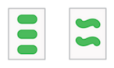

['number', 'color', 'pattern', 'shape'] : [0 1 1 0]


In [11]:
i = np.random.choice(range(1000))
fig, axarr = plt.subplots(1, 2, figsize=(2,1))
for j in range(2):
    card = card_seqs[i,j]
    axarr[j].imshow(image_seqs[i,j])
    axarr[j].axis('off')
plt.show()
print(attrs,':',labels[i])


In [12]:
test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, object_seqs_train, object_seqs_test, labels_train, labels_test = train_test_split(card_seqs, object_seqs, labels, test_size=0.2)

seqs_train, seqs_val, object_seqs_train, object_seqs_val, labels_train, labels_val = \
train_test_split(seqs_train, object_seqs_train, labels_train, test_size=val_size/(1-test_size))

source_train, source_val, source_test = object_seqs_train, object_seqs_val, object_seqs_test


In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()


In [14]:
def create_callbacks(patience=6):
    callbacks = []
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
        patience=patience, min_delta=0, start_from_epoch=20, mode='auto', restore_best_weights=True, verbose=True))
    return callbacks
    
class VectorEmbedder(tf.keras.Model):
    def __init__(self, embedding_dim=64, name='vector_embedder'):
        super().__init__(name=name)
        self.embedding_dim = embedding_dim
        self.embedder = layers.Dense(self.embedding_dim, name='dense')

    def call(self, inputs):
        outputs = self.embedder(inputs)
        return outputs

class SimpleAbstractor(tf.keras.Model):
    def __init__(self, sequence_len, embedding_dim, symbol_dim, embedder=None, name='simplest_abstractor_vectorial'):
        super().__init__(name=name)
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim
        self.symbol_dim = symbol_dim

        if embedder != None:
            self.source_embedder = layers.TimeDistributed(embedder, name='source_embedder')
        else:
            self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        self.source_embedder.trainable = False

        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1., seed=11)
        self.symbols = tf.Variable(
            normal_initializer(shape=(self.sequence_len, self.symbol_dim)),
            name='symbols', trainable=False)
        self.scale = 50
        self.flatten = layers.Flatten()
        self.query_projection = layers.Dense(embedding_dim, activation=None, name='query_projection')
        self.key_projection = layers.Dense(embedding_dim, activation=None, name='key_projection')
        self.hidden_layer = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')

    def call(self, inputs):
        source = inputs
        E = self.source_embedder(source)
        Q = self.query_projection(E)
        K = self.key_projection(E)
        self.Z = self.scale * tf.einsum('ijk,ilk->ijl', Q, K) / self.embedding_dim
        self.R = tf.math.sigmoid(self.Z) # tf.nn.softmax(self.Z, axis=1)
        self.A = tf.einsum('ijk,kl->ijl', self.R, self.symbols)
        flattened_symbols = self.flatten(self.A)
        hidden_units = self.hidden_layer(flattened_symbols)
        output = self.final_layer(hidden_units)
        return output

In [15]:
train_size = 1000
X_train = source_train[:train_size]
y_train = labels_train[:train_size]
X_val = source_val
y_val = labels_val
X_train.shape, X_val.shape
X_test = source_test
y_test = labels_test
X_train.shape, X_val.shape, X_test.shape

((1000, 2, 32), (500, 2, 32), (1000, 2, 32))

In [16]:
embedder = VectorEmbedder(embedding_dim=64)

In [17]:
abstractor = [None, None, None, None]

for i in range(4):
    abstractor[i] = SimpleAbstractor(sequence_len=2, symbol_dim=10, embedding_dim=64, embedder=embedder)
    abstractor[i].compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
    abstractor[i](X_train[:32])
    #abstractor.summary()
    history = abstractor[i].fit(X_train, y_train[:,i], validation_data=(X_val, y_val[:,i]), \
                    callbacks=create_callbacks(), epochs=20, verbose=0, batch_size=32)
    out = abstractor[i](X_test)
    yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
    print('test accuracy of attribute %d (%s): %.2f%%' % (i, attrs[i], 100*np.mean(yhat==y_test[:,i])))


test accuracy of attribute 0 (number): 100.00%
test accuracy of attribute 1 (color): 99.90%
test accuracy of attribute 2 (pattern): 99.30%
test accuracy of attribute 3 (shape): 100.00%


Next we create a dataset of triples of cards, each either a SET or not a SET, together with the relations between the three pairs of cards. The cards are encoded using the CNN that was trained above. The relations are represented as a binary 12-vector for the triple of cards, call them A, B, C. The four groups of three bits are for color, number, pattern, and shape. The first bit in a group indicates whether cards A and B share that attribute; the second bit is for cards A and C, the third bit for cards B and C.

In [18]:
image_seqs, card_seqs, object_seqs, labels, relations = create_set_classification_dataset(5000)


In [19]:

Z_set = image_seqs
X_set = object_seqs
R_set = relations
y_set = labels

Z_set.shape, X_set.shape, R_set.shape, y_set.shape

((5000, 3, 70, 50, 4), (5000, 3, 32), (5000, 12), (5000,))

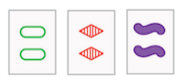

SET? 1
SET? [1 1 1 0 0 0 0 0 0 0 0 0]


In [20]:
i = np.random.choice(range(len(Z_set)))
fig, axarr = plt.subplots(1, 3, figsize=(3,1.5))
for j in range(3):
    axarr[j].imshow(Z_set[i,j])
    axarr[j].axis('off')
plt.show()
print('SET?',y_set[i])
print('SET?',R_set[i])




In [21]:
class SimpleAbstractorMH(tf.keras.Model):
    def __init__(self, sequence_len, embedding_dim, symbol_dim, embedder=None, num_heads=4, name='simplest_abstractor_vectorial_mh', h1=64, h2=64):
        super().__init__(name=name)
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim
        self.symbol_dim = symbol_dim
        self.num_heads = num_heads
        self.h1, self.h2 = (h1, h2)

        if embedder != None:
            self.source_embedder = layers.TimeDistributed(embedder, name='source_embedder')
        else:
            self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        self.source_embedder.trainable = False

        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1., seed=11)
        #self.symbols = tf.matmul(tf.ones((self.sequence_len,1)),
        #    tf.Variable(normal_initializer(shape=(1, self.symbol_dim)),
        #    name='symbols', trainable=False))
        self.symbols = tf.Variable(normal_initializer(shape=(self.sequence_len, self.symbol_dim)),
            name='symbols', trainable=False)
        self.scale = 50
        self.flatten = layers.Flatten()
        
        
        self.query_projection = [None]*self.num_heads
        self.key_projection = [None]*self.num_heads

        for h in range(self.num_heads):
            self.query_projection[h] = layers.Dense(embedding_dim, activation=None, name='query_projection')
            self.key_projection[h] = layers.Dense(embedding_dim, activation=None, name='key_projection')

        self.hidden_layer1 = layers.Dense(self.h1, activation='relu', name='hidden_layer1')
        self.hidden_layer2 = layers.Dense(self.h2, activation='relu', name='hidden_layer2')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')

    def call(self, inputs):
        source = inputs
        E = self.source_embedder(source)

        self.Z = [None]*self.num_heads 
        self.R = [None]*self.num_heads 
        self.A = [None]*self.num_heads 

        for h in range(self.num_heads):
            Q = self.query_projection[h](E)
            K = self.key_projection[h](E)
            self.Z[h] = self.scale * tf.einsum('ijk,ilk->ijl', Q, K) / self.embedding_dim
            #self.Z[h] = tf.math.sigmoid(self.Z[h])
            self.R[h] = tf.math.sigmoid(self.Z[h]) #tf.nn.softmax(5*self.Z[h], axis=1)
            self.A[h] = tf.einsum('ijk,kl->ijl', self.R[h], self.symbols)
            if h==0:
                A = tf.concat([self.A[h]], axis=1)
            else:
                A = tf.concat([A, self.A[h]], axis=1)

        flattened_symbols = self.flatten(A)
        hidden_units = self.hidden_layer1(flattened_symbols)
        hidden_units = self.hidden_layer2(hidden_units)
        output = self.final_layer(hidden_units)
        return output

In [22]:
train_size = 500
val_frac = .2

X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X_set, y_set, Z_set, train_size=int(train_size/(1-val_frac)), test_size=500)
X_train, X_dev, y_train, y_dev, Z_train, Z_dev = train_test_split(X_train, y_train, Z_train, train_size=1-val_frac)
X_train.shape, X_dev.shape, X_test.shape

((500, 3, 32), (125, 3, 32), (500, 3, 32))

In [23]:
abstractor_mh = SimpleAbstractorMH(sequence_len=3, symbol_dim=15, embedding_dim=64, embedder=embedder, num_heads=4)
abstractor_mh(X_set[:32])
abstractor_mh.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])

use_pretrained = True
if (use_pretrained):
    for h in range(4):
        abstractor_mh.query_projection[h].set_weights(abstractor[h].query_projection.get_weights())
        abstractor_mh.query_projection[h].trainable=False
        abstractor_mh.key_projection[h].set_weights(abstractor[h].key_projection.get_weights())
        abstractor_mh.key_projection[h].trainable=False

abstractor_mh.summary()
abstractor_mh.scale = 50
abstractor_mh.scale

Model: "simplest_abstractor_vectorial_mh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 2112      
 buted)                                                          
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 query_projection (Dense)    multiple                  4160      
                                                                 
 query_projection (Dense)    multiple                  4160      
                                                                 
 query_projection (Dense)    multiple                  4160      
                                                                 
 query_projection (Dense)    multiple                  4160      
                                  

50

In [24]:
def create_callbacks(patience=6):
    callbacks = []
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
        patience=patience, min_delta=0, start_from_epoch=20, mode='auto', restore_best_weights=True, verbose=False))
    return callbacks

def initialize_set_abstractor_model(use_pretrained_relations=True):
    abstractor_mh = SimpleAbstractorMH(sequence_len=3, symbol_dim=15, embedding_dim=64, embedder=embedder, num_heads=4)
    abstractor_mh(X_set[:32])
    abstractor_mh.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])

    if (use_pretrained_relations):
        for h in range(4):
            abstractor_mh.query_projection[h].set_weights(abstractor[h].query_projection.get_weights())
            abstractor_mh.query_projection[h].trainable=False
            abstractor_mh.key_projection[h].set_weights(abstractor[h].key_projection.get_weights())
            abstractor_mh.key_projection[h].trainable=False

    #abstractor_mh.summary()
    abstractor_mh.scale = 50
    return abstractor_mh

def set_train_val_test_split(train_size, val_size, test_size):
    X_train, X_test, y_train, y_test = \
        train_test_split(X_set, y_set, train_size=int(train_size/(1-val_frac)), test_size=test_size)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, train_size=1-val_frac)
    return X_train, y_train, X_dev, y_dev, X_test, y_test

def train_set_abstractor_models(train_sizes, num_trials, num_epochs, pretrained=True):
    from tqdm import tqdm
    from sklearn.model_selection import train_test_split
    accs = list()
    n_val = 100
    for n in tqdm(train_sizes):
        trial_accs = []
        for trial in np.arange(num_trials):
            model = initialize_set_abstractor_model(use_pretrained_relations=pretrained)
            X_train, y_train, X_val, y_val, X_test, y_test = \
                set_train_val_test_split(train_size=n, val_size=n_val, test_size=500)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=create_callbacks(), epochs=num_epochs, verbose=0)
            out = model(X_test)
            yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
            acc = 100*np.mean(yhat==y_test)
            trial_accs.append(acc)
        accs.append(trial_accs)
        print('n=%d, accuracy=%.2f' % (n, np.mean(trial_accs, axis=0)))
    return accs

def plot_comparison(pretrained_n, pretrained_accs, scratch_n, scratch_accs):
    import scipy.stats
    scratch_accuracy = np.mean(scratch_accs, axis=1)
    scratch_acc_sem = scipy.stats.sem(scratch_accs, axis=1)
    pretrained_accuracy = np.mean(pretrained_accs, axis=1)
    pretrained_acc_sem = scipy.stats.sem(pretrained_accs, axis=1)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(scratch_n, scratch_accuracy, label='Abstractor trained de novo')
    ax.fill_between(scratch_n, scratch_accuracy - scratch_acc_sem,
        scratch_accuracy + scratch_acc_sem, alpha=0.5)
    ax.plot(pretrained_n, pretrained_accuracy, label='Using pretrained relations')
    ax.fill_between(pretrained_n, pretrained_accuracy - pretrained_acc_sem,
        pretrained_accuracy + pretrained_acc_sem, alpha=0.5)
    ax.set_xlabel('Training Set Size')
    ax.legend()
    ax.set_ylabel('SET Classification Accuracy')
    ax.grid(linestyle='dashed')
    #fig.savefig('set_accuracies.pdf')
    plt.show()

def plot_accuracies(pretrained_n, pretrained_accs):
    import scipy.stats
    pretrained_accuracy = np.mean(pretrained_accs, axis=1)
    pretrained_acc_sem = scipy.stats.sem(pretrained_accs, axis=1)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(pretrained_n, pretrained_accuracy, label='Using pretrained relations')
    ax.fill_between(pretrained_n, pretrained_accuracy - pretrained_acc_sem,
        pretrained_accuracy + pretrained_acc_sem, alpha=0.3)
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('SET Classification Accuracy')
    ax.grid(linestyle='dashed')
    plt.show()


In [25]:
train_sizes = list(np.arange(20, 100, 20)) + list(np.arange(100, 1001, 100))
accs = train_set_abstractor_models(train_sizes=train_sizes, num_trials=10, num_epochs=50)

  7%|▋         | 1/14 [00:29<06:25, 29.67s/it]

n=20, accuracy=53.50


 14%|█▍        | 2/14 [00:59<05:55, 29.60s/it]

n=40, accuracy=57.10


 21%|██▏       | 3/14 [01:27<05:22, 29.34s/it]

n=60, accuracy=58.70


 29%|██▊       | 4/14 [01:57<04:54, 29.42s/it]

n=80, accuracy=66.42


 36%|███▌      | 5/14 [02:28<04:29, 29.99s/it]

n=100, accuracy=65.60


 43%|████▎     | 6/14 [03:01<04:06, 30.80s/it]

n=200, accuracy=82.44


 50%|█████     | 7/14 [03:38<03:47, 32.56s/it]

n=300, accuracy=92.76


 57%|█████▋    | 8/14 [04:14<03:23, 33.84s/it]

n=400, accuracy=94.76


 64%|██████▍   | 9/14 [04:54<02:58, 35.62s/it]

n=500, accuracy=95.56


 71%|███████▏  | 10/14 [05:36<02:29, 37.32s/it]

n=600, accuracy=97.30


 79%|███████▊  | 11/14 [06:18<01:56, 39.00s/it]

n=700, accuracy=98.22


 86%|████████▌ | 12/14 [07:02<01:20, 40.23s/it]

n=800, accuracy=98.44


 93%|█████████▎| 13/14 [07:50<00:42, 42.80s/it]

n=900, accuracy=98.28


100%|██████████| 14/14 [08:39<00:00, 37.11s/it]

n=1000, accuracy=98.84


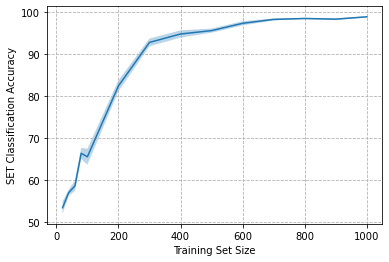

In [26]:
plot_accuracies(train_sizes, accs)


In [27]:
class SymbolicClassifier(tf.keras.Model):
    def __init__(self, sequence_len, h1=16, h2=8, name='symbolic_classifier'):
        super().__init__(name=name)
        self.sequence_len = sequence_len
        self.h1, self.h2 = (h1,h2)
        self.hidden_layer1 = layers.Dense(self.h1, activation='relu', name='hidden_layer1')
        self.hidden_layer2 = layers.Dense(self.h2, activation='relu', name='hidden_layer2')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')

    def call(self, inputs):
        source = inputs
        hidden_units = self.hidden_layer1(source)
        hidden_units = self.hidden_layer2(hidden_units)
        output = self.final_layer(hidden_units)
        return output

In [28]:
symbolic_model = SymbolicClassifier(3)
symbolic_model(R_set[:32])
symbolic_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
symbolic_model.summary()


Model: "symbolic_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       multiple                  208       
                                                                 
 hidden_layer2 (Dense)       multiple                  136       
                                                                 
 final_layer (Dense)         multiple                  9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [29]:
def create_callbacks(patience=6):
    callbacks = []
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
        patience=patience, min_delta=0, start_from_epoch=20, mode='auto', restore_best_weights=True, verbose=False))
    return callbacks

def initialize_set_symbolic_model():
    model = SymbolicClassifier(sequence_len=3)
    model(R_set[:32])
    model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
    return model

def set_symbolic_train_val_test_split(train_size, val_size, test_size):
    from sklearn.model_selection import train_test_split
    R_train, R_test, y_train, y_test = \
        train_test_split(R_set, y_set, train_size=int(train_size/(1-val_frac)), test_size=test_size)
    R_train, R_dev, y_train, y_dev = train_test_split(R_train, y_train, train_size=1-val_frac)
    return R_train, y_train, R_dev, y_dev, R_test, y_test

def train_set_symbolic_models(train_sizes, num_trials, num_epochs, pretrained=True):
    from tqdm import tqdm
    accs = list()
    n_val = 100
    for n in tqdm(train_sizes):
        trial_accs = []
        for trial in np.arange(num_trials):
            model = initialize_set_symbolic_model()
            R_train, y_train, R_val, y_val, R_test, y_test = \
                set_symbolic_train_val_test_split(train_size=n, val_size=n_val, test_size=500)
            model.fit(R_train, y_train, validation_data=(R_val, y_val), callbacks=create_callbacks(), epochs=num_epochs, verbose=0)
            out = model(R_test)
            yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
            acc = 100*np.mean(yhat==y_test)
            trial_accs.append(acc)
        accs.append(trial_accs)
        print('n=%d, accuracy=%.2f' % (n, np.mean(trial_accs, axis=0)))
    return accs


In [30]:
symbolic_train_sizes = list(np.arange(10, 100, 10)) + list(np.arange(100, 1001, 200))
symbolic_accs = train_set_symbolic_models(train_sizes=symbolic_train_sizes, num_trials=10, num_epochs=50)


  7%|▋         | 1/14 [00:15<03:20, 15.46s/it]

n=10, accuracy=52.68


 14%|█▍        | 2/14 [00:29<03:00, 15.01s/it]

n=20, accuracy=50.68


 21%|██▏       | 3/14 [00:45<02:48, 15.31s/it]

n=30, accuracy=56.78


 29%|██▊       | 4/14 [01:04<02:44, 16.47s/it]

n=40, accuracy=58.48


 36%|███▌      | 5/14 [01:27<02:45, 18.44s/it]

n=50, accuracy=62.24


 43%|████▎     | 6/14 [01:44<02:24, 18.06s/it]

n=60, accuracy=62.82


 50%|█████     | 7/14 [02:02<02:06, 18.01s/it]

n=70, accuracy=68.54


 57%|█████▋    | 8/14 [02:21<01:49, 18.29s/it]

n=80, accuracy=68.16


 64%|██████▍   | 9/14 [02:41<01:33, 18.76s/it]

n=90, accuracy=78.24


 71%|███████▏  | 10/14 [03:00<01:15, 18.95s/it]

n=100, accuracy=73.32


 79%|███████▊  | 11/14 [03:23<01:00, 20.17s/it]

n=300, accuracy=96.74


 86%|████████▌ | 12/14 [03:49<00:43, 21.89s/it]

n=500, accuracy=98.72


 93%|█████████▎| 13/14 [04:20<00:24, 24.56s/it]

n=700, accuracy=99.14


100%|██████████| 14/14 [04:57<00:00, 21.23s/it]

n=900, accuracy=99.16


In [31]:
def plot_symbolic_comparison(pretrained_n, pretrained_accs, scratch_n, scratch_accs):
    import scipy.stats
    scratch_accuracy = np.mean(scratch_accs, axis=1)
    scratch_acc_sem = scipy.stats.sem(scratch_accs, axis=1)
    pretrained_accuracy = np.mean(pretrained_accs, axis=1)
    pretrained_acc_sem = scipy.stats.sem(pretrained_accs, axis=1)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(scratch_n, scratch_accuracy, label='MLP with purely symbolic input')
    ax.fill_between(scratch_n, scratch_accuracy - 2*scratch_acc_sem,
        scratch_accuracy + 2*scratch_acc_sem, alpha=0.5)
    ax.plot(pretrained_n, pretrained_accuracy, label='Abstractor on images, pre-learned relations')
    ax.fill_between(pretrained_n, pretrained_accuracy - 2*pretrained_acc_sem,
        pretrained_accuracy + 2*pretrained_acc_sem, alpha=0.5)
    ax.set_xlabel('Training Set Size')
    ax.legend()
    ax.set_ylabel('SET Classification Accuracy')
    ax.grid(linestyle='dashed')
    fig.savefig('set_symbolic_vs_abstractor.pdf')
    plt.show()

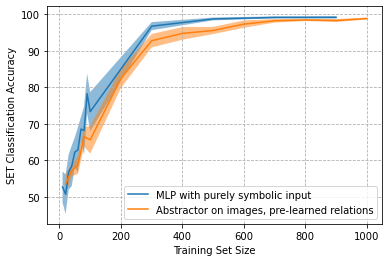

In [32]:
plot_symbolic_comparison(train_sizes, accs, symbolic_train_sizes, symbolic_accs)

In [33]:
np.savez('symbolic_vs_abstractor', train_sizes=train_sizes, accs=accs, symbolic_train_sizes=symbolic_train_sizes, symbolic_accs=symbolic_accs)


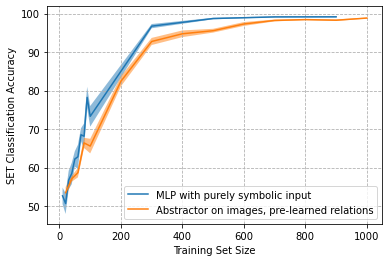

In [34]:
def plot_symbolic_comparison(pretrained_n, pretrained_accs, scratch_n, scratch_accs):
    import scipy.stats
    scratch_accuracy = np.mean(scratch_accs, axis=1)
    scratch_acc_sem = scipy.stats.sem(scratch_accs, axis=1)
    pretrained_accuracy = np.mean(pretrained_accs, axis=1)
    pretrained_acc_sem = scipy.stats.sem(pretrained_accs, axis=1)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(scratch_n, scratch_accuracy, label='MLP with purely symbolic input')
    ax.fill_between(scratch_n, scratch_accuracy - scratch_acc_sem,
        scratch_accuracy + scratch_acc_sem, alpha=0.5)
    ax.plot(pretrained_n, pretrained_accuracy, label='Abstractor on images, pre-learned relations')
    ax.fill_between(pretrained_n, pretrained_accuracy - pretrained_acc_sem,
        pretrained_accuracy + pretrained_acc_sem, alpha=0.5)
    ax.set_xlabel('Training Set Size')
    ax.legend()
    ax.set_ylabel('SET Classification Accuracy')
    ax.grid(linestyle='dashed')
    fig.savefig('set_symbolic_vs_abstractor.pdf')
    plt.show()

dat = np.load('symbolic_vs_abstractor.npz')
train_sizes = dat['train_sizes']
accs = dat['accs']
symbolic_train_sizes = dat['symbolic_train_sizes']
symbolic_accs = dat['symbolic_accs']
plot_symbolic_comparison(train_sizes, accs, symbolic_train_sizes, symbolic_accs)